In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import GCRCatalogs
from shear_azimuthal_averager import ShearAzimuthalAverager

### Read in the extragalactic catalog
- identify the most massive halo
- create a cluster dictionary (ra, dec, z)

In [18]:
extragalactic_cat = GCRCatalogs.load_catalog('proto-dc2_v2.1.2_test')

# get a massive halo!
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=['halo_mass > 1e14','is_central==True'])

m = massive_halos['halo_mass']
select = (m == np.max(m))
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
m_cl = m[select][0]
print(m_cl, ra_cl, dec_cl, z_cl)

# make a dictionary for cluster
cl_dict = {'z':z_cl, 'ra':ra_cl, 'dec': dec_cl}


5.95589e+14 1.15419 2.20399 0.354081722946


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/envs/clmassmod-nostack/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


### Apply coordinates and redshift cuts to select backgroud galaxies around the cluster

In [19]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
z_max = 1.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]
z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))

# store the results into an astropy table
t = Table([gal_cat['galaxy_id'],gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['convergence']], \
          names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))


### Computes the tangential and cross shear profiles

#### Default binning

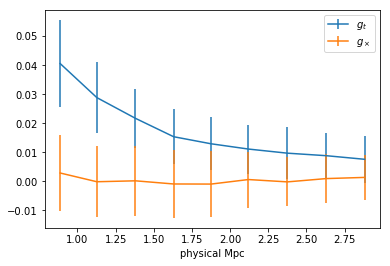

In [20]:
# create an object, given cluster dictionary and galaxy astropy table
saa = ShearAzimuthalAverager(cl_dict,t)

# compute tangential and cross shear for each galaxy
saa.compute_shear()

# make the binned profile
binned_profile = saa.make_shear_profile()

saa.plot_profile()   

### Set up a model, using the Dallas group tools

In [21]:
import sys
sys.path.append('../models/')
import CLMM_densityModels_beforeConvertFromPerH as clmm
import numpy as np
import colossus.cosmology.cosmology as Cosmology
import matplotlib.pyplot as plt
import time

zL = z_cl
chooseCosmology = 'WMAP7-ML' #Choose cosmology used
cosmo = Cosmology.setCosmology(chooseCosmology)

mdef = '200c'
M = m_cl*cosmo.h
c = 4.
r = np.linspace(0.5, 3., 100) #Mpc
r = r*cosmo.h #Mpc/h

testProf= clmm.nfwProfile(M = M, c = c, zL = zL, mdef = mdef, \
                        chooseCosmology = chooseCosmology, esp = None)


In [22]:
z_infty = 300
zL_arr = np.zeros(len(t['z'])) + zL

In [23]:
D_LS = (cosmo.comovingDistance(z_min=0.,z_max=t['z']) - cosmo.comovingDistance(z_min=0.,z_max=zL))/(1.+t['z'])
D_Linfty = (cosmo.comovingDistance(z_min=0., z_max=z_infty) - cosmo.comovingDistance(z_min=0., z_max=zL))/(1.+z_infty)
beta = D_LS * cosmo.angularDiameterDistance(z_infty)/cosmo.angularDiameterDistance(t['z'])/D_Linfty

In [24]:
r_phys = binned_profile['radius']
gt_mod = np.zeros(len(r_phys))

for ir, r in enumerate(r_phys):
    gamtest_infty= testProf.deltaSigma(np.array([r])*0.7)/testProf.Sc(z_infty)
    kappa_infty =  testProf.Sigma(np.array([r])*0.7)/testProf.Sc(z_infty)
    gt_mod[ir] = np.mean(beta * gamtest_infty/(1-beta*kappa_infty))

<Container object of 3 artists>

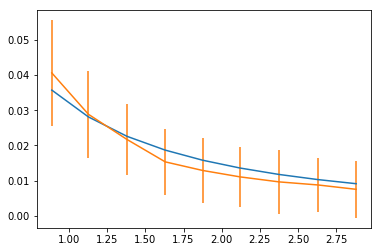

In [25]:
plt.plot(r_phys, gt_mod)
plt.errorbar(r_phys, binned_profile['g_t'], yerr=binned_profile['g_t_err'])
